In [20]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import os
import PIL

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
GPU is NOT AVAILABLE


In [6]:
module_selection = ("mobilenet_v2_100_224", 224) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


#  Setup dataset

In [8]:
data_dir = tf.keras.utils.get_file(
    'garbageclassification',
    'http://d668966ed0a6.ngrok.io/garbageclassification.tgz',
    untar=True)



65699840/65698608 [==============================] - 96s 1us/step


In [22]:
import pathlib
data_dir2 = pathlib.Path(data_dir)
image_count = len(list(data_dir2.glob('*/*.jpg')))
print(image_count)

2540


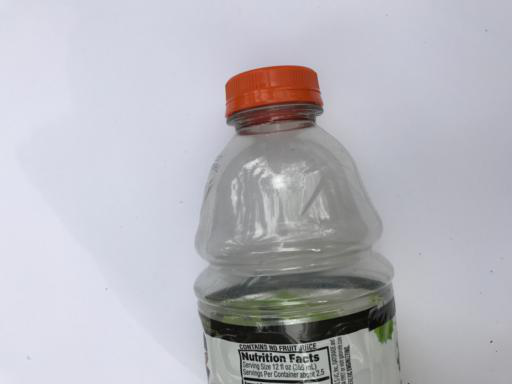

In [24]:
plastic = list(data_dir2.glob('plastic/*'))
PIL.Image.open(str(plastic[0]))

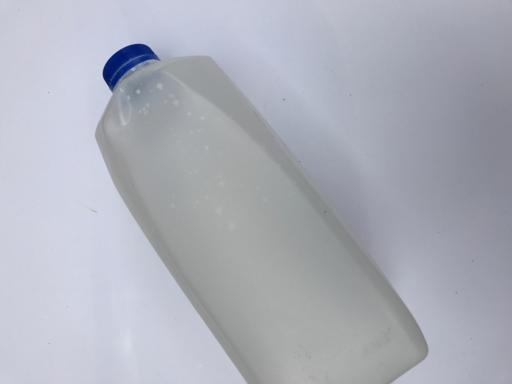

In [26]:
PIL.Image.open(str(plastic[2]))

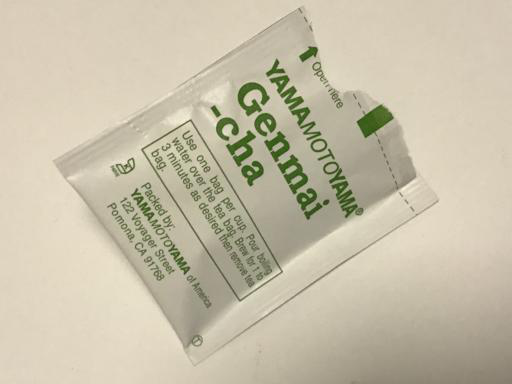

In [28]:
wrapper = list(data_dir2.glob('wrapper/*'))
PIL.Image.open(str(wrapper[0]))

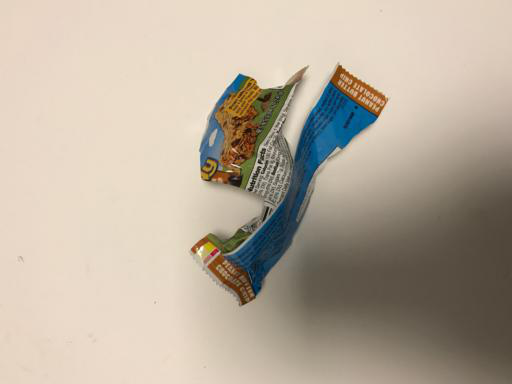

In [30]:
PIL.Image.open(str(wrapper[5]))

In [4]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, 
                      batch_size=BATCH_SIZE,
                      interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", 
    shuffle=False, **dataflow_kwargs)

NameError: ignored

In [33]:
do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                        rotation_range=40,
                                                        horizontal_flip=True,
                                                        width_shift_range=0.2, 
                                                        height_shift_range=0.2,
                                                        shear_range=0.2, 
                                                        zoom_range=0.2,
                                                        **datagen_kwargs)
else:
  train_datagen = valid_datagen

train_generator = train_datagen.flow_from_directory(
                                                    data_dir, 
                                                    subset="training", 
                                                    shuffle=True, 
                                                    **dataflow_kwargs)

Found 2034 images belonging to 6 classes.


In [52]:
class_names = train_generator.class_indices.items()
print(class_names)

dict_items([('cardboard', 0), ('glass', 1), ('metal', 2), ('paper', 3), ('plastic', 4), ('wrapper', 5)])


# visulaize the data 

In [93]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_generator.index_array.any:
#   print(labels)
#   print(images)
#   for i in range(6):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")



In [3]:
# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# ML, statistics
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

train_generator.statistics

df = sns.load_dataset(train_generator) 
sns.countplot(x='catagories', data=df)

# data_dir2.value_counts().plot(kind='bar')
# plt.title('Labels counts')
# plt.xlabel('Label')
# plt.ylabel('Count')
# plt.show()

NameError: ignored

In [61]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 6)


# Defining the model

In [10]:
do_fine_tuning = False 

In [11]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


# Training the model

In [13]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [14]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data = valid_generator,
    validation_steps = validation_steps).history

Epoch 1/5
63/63 [==============================] - 95s 2s/step - loss: 1.1888 - accuracy: 0.6389 - val_loss: 1.0136 - val_accuracy: 0.7333
Epoch 2/5
63/63 [==============================] - 94s 1s/step - loss: 0.8493 - accuracy: 0.8122 - val_loss: 0.9283 - val_accuracy: 0.7542
Epoch 3/5
63/63 [==============================] - 93s 1s/step - loss: 0.7730 - accuracy: 0.8452 - val_loss: 0.9812 - val_accuracy: 0.7333
Epoch 4/5
63/63 [==============================] - 93s 1s/step - loss: 0.7359 - accuracy: 0.8786 - val_loss: 0.9564 - val_accuracy: 0.7583
Epoch 5/5
63/63 [==============================] - 92s 1s/step - loss: 0.6978 - accuracy: 0.8941 - val_loss: 0.9767 - val_accuracy: 0.7396


In [ ]:
conf_mat = confusion_matrix(np.argmax(train_generator,axis = 1),model.predict(train_generator))
print(conf_mat)

In [102]:
from keras.preprocessing import image 
  
# Pre-processing the image 
img = image.load_img(data_dir.index[2], target_size = (150, 150)) 
img_tensor = image.img_to_array(img) 
img_tensor = np.expand_dims(img_tensor, axis = 0) 
img_tensor = img_tensor / 255.
  
# Print image tensor shape 
print(img_tensor.shape) 
  
# Print image 
import matplotlib.pyplot as plt 
plt.imshow(img_tensor[0]) 
plt.show() 

TypeError: ignored

Text(0.5, 1.0, 'Training and Validation Accuracy')

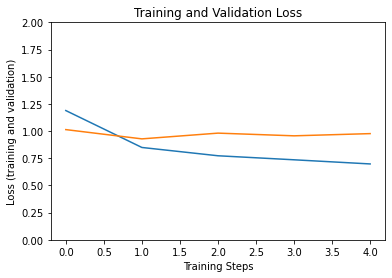

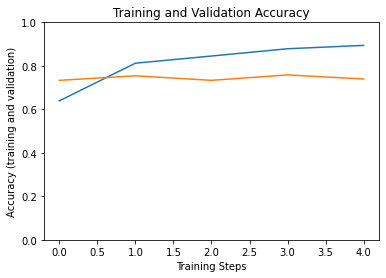

In [73]:
plt.figure()
plt.ylabel("Loss ")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title('Training and Validation Loss')

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

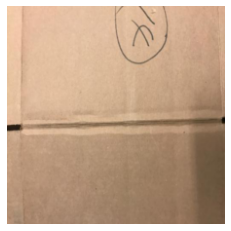

True label: cardboard
Predicted label: cardboard


In [16]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

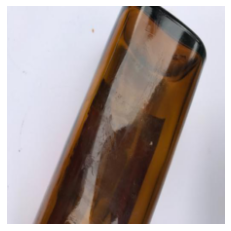

True label: glass
Predicted label: glass


In [84]:
x, y = valid_generator[4]
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()


prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

# Save the Model 

In [17]:
saved_model_path = "/tmp/saved_garbageclassification_model"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_garbageclassification_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_garbageclassification_model/assets
